In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (precision_score, recall_score,
                             precision_recall_curve,f1_score, 
                             fbeta_score, confusion_matrix)


from splits import split_users # contains split_users func

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 100)


In [2]:
# read in pickled feature DF generated by feature_engineering_3.ipynb
X = pd.read_pickle("./pickle/X_F.pickle")

In [3]:
with open(f"models/xgboost_fit_all.pickle", "rb") as pfile:
        xgb_fit = pickle.load(pfile)

In [4]:
X_train, X_test, y_train, y_test = split_users(X, subset=False, test_size=0.2)


    X_train sample size: 6782401
    X_test sample size: 1692260


In [5]:
xgb_fit.score(X_test, y_test)

0.9098140947608524

In [6]:
preds = xgb_fit.predict(X_test)

In [7]:
f1_score(y_test, preds)

0.2723744684097107

# Determining the Optimal Probability Threshold

What will Instacart use this model for?

This is an important question to consider at every stage, especially when determining our probability threshold. We can adjust the threshold meter in the below confusion matrix to determine the optimal probability threshold our model uses to classify inputs. A higher threshold means the model will be less likely to classify an input as a 'reorder'. A lower threshold results in more `1` predictions. If our model were a person, the person would *need less convincing* to predict `1` with a *lower threshold*.

**So...what does that mean for our Instacart dataset?**

Instacart uses the model's predictions for two use-cases (per their [blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)):
1. "Buy it Again?" user prompts
2. "Frequently bought with..." user prompt when shopping


In both cases, the 'risk' of making false reorder predictions seems pretty low (if any). In practice, this means to prioritize **recall** (`predicted positives / all positives`) & reduce false negatives as much as possible. We'll intentionally be inflating our false positives (incorrectly predicting an item as a reorder in the user's next cart). Doing this should benefit Instacart, as highlighting these items to the user may increase conversion.

In summary, **our goal is find a low enough probability threshold in which items that the user *might* purchase are captured, while still correctly classifying products the user is very unlikely to purchase.** In practice, this means that we'll be using the F-2 measure to calculate the optimal threshold for recall. F-1 is the most common metric for this, but F-2 will better for prioritizing recall. F-1 is a 'balanced' measure of precision vs. recall.

Let's try and find a reasonable probability threshold using the below slider & confusion matrix.

In [8]:
def make_confusion_matrix(model, threshold=0.5, title=None):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    
    confusion = confusion_matrix(y_test, y_predict)
    
    fig, ax = plt.subplots(dpi=80, figsize=(6, 6))
    
    group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
    labels = [f"{v2}\n\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    label_font = {'family': 'Lato',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 23,
        }
    
    title_font = {'family': 'Lato',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 27,
        }
    
    sns.set(font_scale=1.6)
    # good cmaps: RdYlBu, coolwarm, RdBu
    sns.heatmap(confusion, annot=labels, fmt="", cmap="RdBu", cbar=False,
               xticklabels=['no_reorder', 'reorder'],
               yticklabels=['no_reorder', 'reorder'])
    
    if title == None:
        title = "Confusion Matrix"
    plt.title(title, fontdict=label_font)
    plt.xlabel('Prediction', fontdict=label_font)
    plt.ylabel('Actual', fontdict=label_font)


In [9]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(xgb_fit, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [10]:
threshold = 0.14

y_predict = (xgb_fit.predict_proba(X_test)[:, 1] >= threshold)

confusion = confusion_matrix(y_test, y_predict)

Optimal threshold based on playing with slider in above confusion matrix: 0.14

So what's our new precision and F1 metrics, using this threshold?

**Precision = TruePositives / (TruePositives + FalsePositives)**

**Recall = TruePositives / (TruePositives + FalseNegatives)**

**But do we really want F-1 score?**



In [11]:
confusion

array([[1264308,  262597],
       [  56154,  109201]])

In [12]:
true_pos = confusion[1][1]
true_neg = confusion[0][0]

false_pos = confusion[0][1]
false_neg = confusion[1][0]

In [13]:
precision = true_pos / (true_pos + false_pos)

precision

0.29371056326284706

In [14]:
recall = true_pos / (true_pos + false_neg)

recall

0.6604033745577697

And now...our adjusted F-1 score

F-1 = (2 * Precision * Recall) / (Precision + Recall)

In [15]:
f1 = (2 * precision * recall) / (precision + recall)

f1

0.40659179042097876

In [16]:
type(xgb_fit)

xgboost.sklearn.XGBClassifier

In [17]:
def get_threshold_scores(model, X_test, y_test, min_threshold=0.01, max_threshold=1.0, beta=2):
    """
        Returns 4 threshold:metric mappers for four metrics:
            - f1_thresholds
            - f2_thresholds
            - f2_precision_thresholds
            - f2_recall_thresholds
    """
    
    f1_thresholds = {}
    f2_thresholds = {}
    f2_precision_thresholds = {}
    f2_recall_thresholds = {}
    
    for threshold in np.arange(min_threshold, max_threshold, 0.01):
        t = round(threshold, 2)
        
        # create confusion matrix
        preds = (model.predict_proba(X_test)[:, 1] >= t)
        confusion = confusion_matrix(y_test, preds)
        
        # extract values needed for precision/recall/f-1 calculations
        true_pos = confusion[1][1]
        false_pos = confusion[0][1]
        false_neg = confusion[1][0]
        
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f_1 = (2 * precision * recall) / (precision + recall)
        f_beta = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
        f1_thresholds[threshold] = f_1
        f2_thresholds[threshold] = f_beta
        f2_precision_thresholds[threshold] = precision
        f2_recall_thresholds[threshold] = recall
        
        
        print(f"End calculating {t*100}%. F-1 score: {f_1:.6f} | F-2 score: {f_beta:.6f}")
    
    return f1_thresholds, f2_thresholds, f2_precision_thresholds, f2_recall_thresholds

f1_thresholds, f2_thresholds, f2_precision_thresholds, f2_recall_thresholds = (get_threshold_scores(
                                    xgb_fit, X_test, y_test, min_threshold=0.01, max_threshold=0.99))


End calculating 1.0%. F-1 score: 0.178029 | F-2 score: 0.351269
End calculating 2.0%. F-1 score: 0.179655 | F-2 score: 0.353761
End calculating 3.0%. F-1 score: 0.205719 | F-2 score: 0.391268
End calculating 4.0%. F-1 score: 0.240927 | F-2 score: 0.435915
End calculating 5.0%. F-1 score: 0.266482 | F-2 score: 0.463968
End calculating 6.0%. F-1 score: 0.288592 | F-2 score: 0.484747
End calculating 7.000000000000001%. F-1 score: 0.310925 | F-2 score: 0.502678
End calculating 8.0%. F-1 score: 0.330051 | F-2 score: 0.515046
End calculating 9.0%. F-1 score: 0.346299 | F-2 score: 0.523181
End calculating 10.0%. F-1 score: 0.361029 | F-2 score: 0.528536
End calculating 11.0%. F-1 score: 0.374797 | F-2 score: 0.531387
End calculating 12.0%. F-1 score: 0.386346 | F-2 score: 0.532034
End calculating 13.0%. F-1 score: 0.396790 | F-2 score: 0.530893
End calculating 14.000000000000002%. F-1 score: 0.406592 | F-2 score: 0.528451
End calculating 15.0%. F-1 score: 0.414715 | F-2 score: 0.524202
End ca

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 87.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 88.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 89.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 90.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 91.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 92.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 93.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 94.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 95.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 96.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


End calculating 97.0%. F-1 score: nan | F-2 score: nan
End calculating 98.0%. F-1 score: nan | F-2 score: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


In [18]:
#setup threshold plot
X_thresholds = f1_thresholds.keys()
y_f1 = f1_thresholds.values()
y_f2 = f2_thresholds.values()

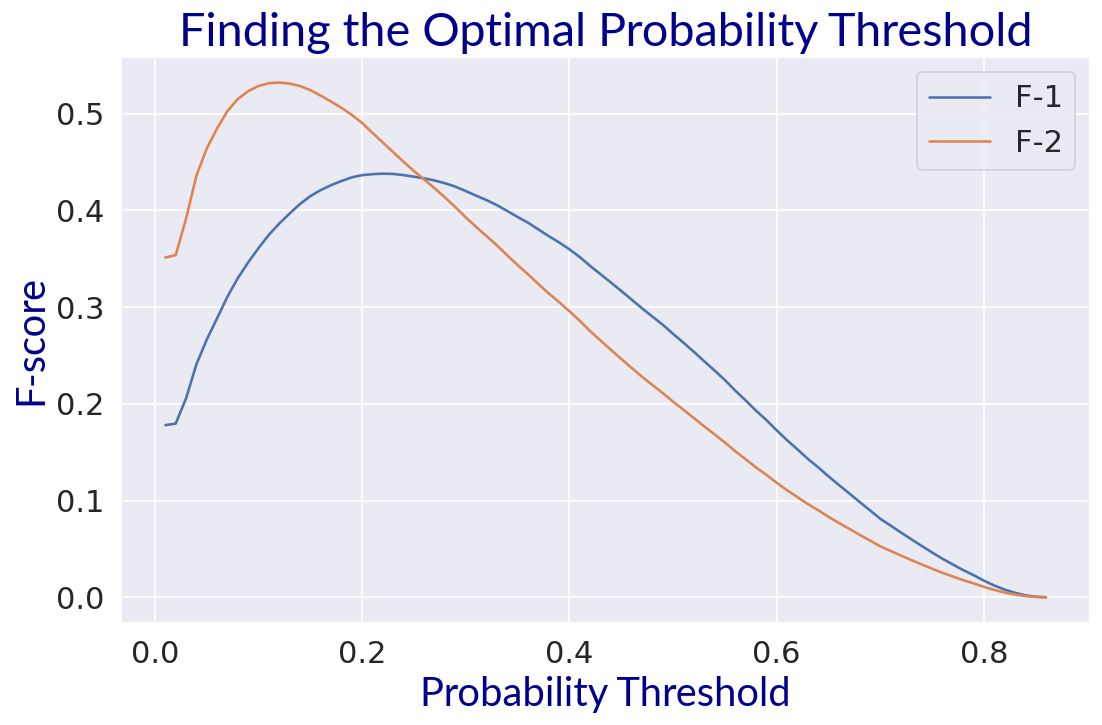

In [19]:
plt.figure(figsize=(10, 6), facecolor='white', dpi=125)

label_font = {'family': 'Lato',
    'color':  'darkblue',
    'weight': 'normal',
    'size': 23,
    }

title_font = {'family': 'Lato',
    'color':  'darkblue',
    'weight': 'normal',
    'size': 27,
    }

plt.plot(X_thresholds, y_f1)
plt.plot(X_thresholds, y_f2)
plt.title("Finding the Optimal Probability Threshold", fontdict=title_font)
plt.xlabel("Probability Threshold", fontdict=label_font)
plt.ylabel("F-score", fontdict=label_font)
plt.legend(["F-1", "F-2"])
# ax.grid(color='black', linestyle='-', linewidth=0.7)

# ax.set_facecolor("white")

In [20]:
with open("pickle/f1_thresholds.pickle", "wb") as p:
    pickle.dump(f1_thresholds, p)
    
with open("pickle/f2_thresholds.pickle", "wb") as p:
    pickle.dump(f2_thresholds, p) 
    
with open("pickle/f2_precision_thresholds.pickle", "wb") as p:
    pickle.dump(f2_precision_thresholds, p)
    
with open("pickle/f2_recall_thresholds.pickle", "wb") as p:
    pickle.dump(f2_recall_thresholds, p) 

In [21]:
def pull_optimal_fs(f1_thresholds, f2_thresholds):
    """
    Parameters
    _____
    f2_thresholds(dict, required): Mapping, like {probability_threshold: f2_score}
    
    Returns:
    _____
    String containing the threshold parameter resulting in the highest F-2 score.
    """
    # pull the threshold with the highest f-1 score
    max_f1 = (0, 0)
    max_f2 = (0, 0)
    
    for thresh, f1 in f1_thresholds.items():    
        if f1 > max_f1[1]:
            max_f1 = thresh, f1
        continue

    for thresh, f2 in f2_thresholds.items():
        if f2 > max_f2[1]:
            max_f2 = thresh, f2
        continue
    
    return max_f1, max_f2
        
        
max_f1, max_f2 = pull_optimal_fs(f1_thresholds, f2_thresholds)

In [22]:
max_f1, max_f2

((0.22, 0.43790029960499305), (0.12, 0.5320339507905493))

## Now we have our optimal threshold (in terms of F2).

Details:
* Threshold: `0.12`
* Resulting F-2 score: `0.532034`

**Let's take a look at how our new predictions look using this probability threshold.**


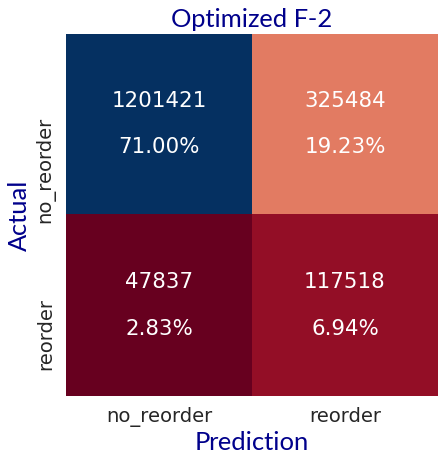

In [23]:
make_confusion_matrix(xgb_fit, threshold=0.12, title='Optimized F-2')

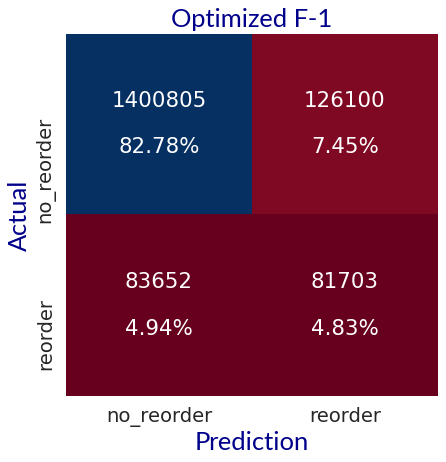

In [24]:
make_confusion_matrix(xgb_fit, threshold=0.22, title='Optimized F-1')

In [25]:
optimal_threshold = 0.12

In [26]:
preds = xgb_fit.predict(X_test)

In [27]:
preds_praba = xgb_fit.predict_proba(X_test)[:, 1] >= optimal_threshold

In [28]:
f1_score(y_test, preds)

0.2723744684097107

In [29]:
precision_score(y_test, preds)

0.6434573018268646

In [30]:
recall_score(y_test, preds)

0.1727495388709141

# Precision/Recall

In [58]:
#setup precision/recall graph

no_skill = len(y_test[y_test==1]) / len(y_test)

recall = np.array(list(f2_recall_thresholds.keys()))
precision = np.array(list(f2_precision_thresholds.values()))
np.nan_to_num(precision, 0)
recall, precision

(array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
        0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
        0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
        0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
        0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]),
 array([0.09771253, 0.09869696, 0.11490306, 0.13802662, 0.15589137,
        0.17235334, 0.19007812, 0.20645817, 0.22149206, 0.23624289,
        0.25134972, 0.26527645, 0.27923286, 0.29371056, 0.30762797,
        0.32046371, 0.3325662 , 0.3444846 , 0.3570534 , 0.36900374,
        0.38096221, 0.39317527, 0.40472409, 0.4154    , 0.42541123

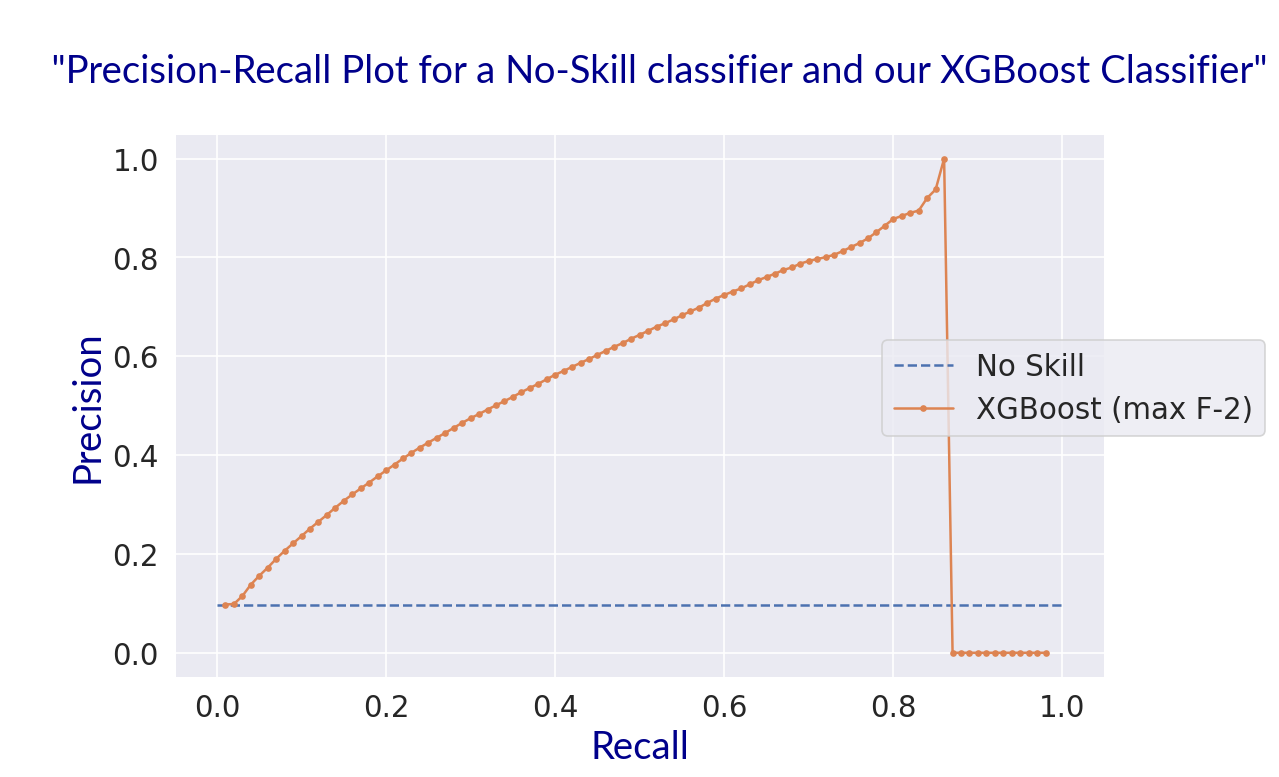

In [59]:
label_font = {'family': 'Lato',
    'color':  'darkblue',
    'weight': 'normal',
    'size': 23,
    }

title_font = {'family': 'Lato',
    'color':  'darkblue',
    'weight': 'normal',
    'size': 27,
    }

title = """
    "Precision-Recall Plot for a No-Skill classifier and our XGBoost Classifier"
    """

ax = plt.figure(figsize=(10, 6), dpi=120)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label="No Skill")
plt.plot(recall, precision, marker='.', label="XGBoost (max F-2)")

plt.title(title, fontdict=label_font)
plt.xlabel("Recall", fontdict=label_font)
plt.ylabel("Precision", fontdict=label_font)
ax.legend(loc='center right')